# Customer Spending & Transaction Analysis

The Dataset was obtained through Kaggle.

- [Customer Demographics and Spending dataset](https://www.kaggle.com/datasets/simranjitkhehra/customer-demographics-and-spending)
- [Customer Transactions dataset](https://www.kaggle.com/datasets/bkcoban/customer-transactions)
    
This notebook analyzes customer demographics, spending habits, and transaction patterns to uncover actionable insights. Merging of the two datasets was not done as the customer_id (primary key) was just made up and the two datasets are not linked together.

## CUSTOMER DEMOGRAPHICS AND SPENDING DATASET

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import text
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

server = "localhost\SQLEXPRESS"
database = "CustomerDB"
driver = "ODBC Driver 17 for SQL Server"

connection_string = f"mssql+pyodbc://@{server}/{database}?driver={driver}"
engine = create_engine(connection_string)

In [2]:
#quick preview
query = """
    SELECT TOP 10 *
    FROM customer_demographics;
    """

df_preview = pd.read_sql(query, engine)
print(df_preview)

   Customer_ID  Age  Gender    Income Product_Category  Spending  \
0            1   61  Female  114940.0       Home Goods   2484.40   
1            2   21  Female   56487.0        Groceries   1334.28   
2            3   21  Female   97556.0       Home Goods   3647.36   
3            4   67  Female  130971.0      Electronics   2882.30   
4            5   73    Male  125964.0        Groceries   2651.44   
5            6   27    Male   81114.0        Groceries   3326.88   
6            7   35    Male   71817.0        Groceries   4121.58   
7            8   71    Male   84165.0       Home Goods   3724.37   
8            9   32  Female   34997.0       Home Goods    524.86   
9           10   27  Female  127168.0      Electronics   2857.54   

          Region  monthly_income  
0  North America     9578.333333  
1         Europe     4707.250000  
2  North America     8129.666666  
3  South America    10914.250000  
4         Europe    10497.000000  
5  South America     6759.500000  
6     

In [3]:
#add monthly income column, if it exists, it drops then recreates
query = """
IF EXISTS (
    SELECT 1 
    FROM sys.columns 
    WHERE Name = N'monthly_income' 
      AND Object_ID = Object_ID(N'dbo.customer_demographics')
)
BEGIN
    ALTER TABLE dbo.customer_demographics
    DROP COLUMN monthly_income;
END;

ALTER TABLE dbo.customer_demographics
ADD monthly_income AS (TRY_CAST(Income AS DECIMAL(18,2)) / 12.0) PERSISTED;
"""

with engine.begin() as conn:
    conn.execute(text(query))
    print("Column recreated successfully")

Column recreated successfully


## Basic Profiling 

In [4]:
#Customer count
query = """
    SELECT COUNT(*) AS total_customers
    FROM customer_demographics
    WHERE Income IS NOT NULL 
        AND Spending IS NOT NULL
    """

df_total_customers = pd.read_sql(query, engine)

#Gender distribution
query = """
    SELECT Gender, 
        COUNT(*) AS count
    FROM customer_demographics
    WHERE Gender IS NOT NULL
        AND Income IS NOT NULL 
        AND Spending IS NOT NULL
    GROUP BY Gender
    """

df_gender_distribution = pd.read_sql(query, engine)

#Income range
query = """
    SELECT MIN(income) AS min_income,
        MAX(income) AS max_income,
        AVG(income) AS avg_income
    FROM customer_demographics
    WHERE Income IS NOT NULL 
        AND Spending IS NOT NULL
    """

df_income_range = pd.read_sql(query, engine)


print(df_total_customers)
print(df_gender_distribution)
print(df_income_range)

   total_customers
0            10000
   Gender  count
0    Male   4950
1  Female   5050
   min_income  max_income  avg_income
0     20006.0    149998.0   84113.347


## Customer Demographics Analysis

### Questions to answer:

#### &emsp; 1. Average spending by Region and Gender
#### &emsp; 2. Income/Spending habits by Age and Product Category

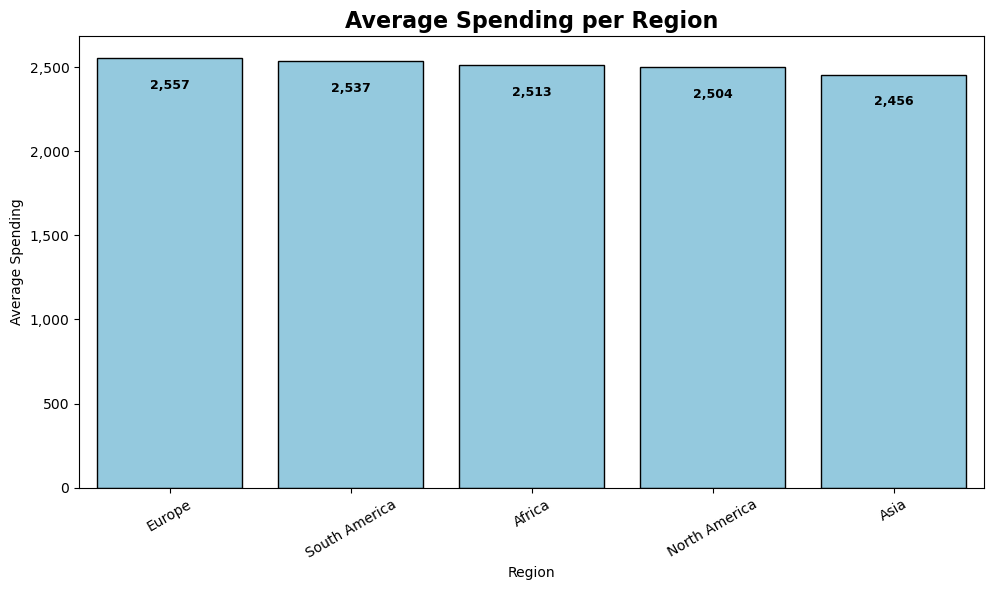

In [5]:
# Average spending per region
query = """
    SELECT Region, 
        AVG(Spending) AS avg_spending
    FROM customer_demographics
    WHERE Spending IS NOT NULL
    GROUP BY Region
    ORDER BY avg_spending DESC
    """

df_avg_spending = pd.read_sql(query, engine)

plt.figure(figsize = (10,6))

ax = sn.barplot(x = "Region", y = "avg_spending", data = df_avg_spending, color = "skyblue", edgecolor = "black")

plt.title("Average Spending per Region", fontsize = 16, weight = "bold")
plt.xlabel("Region")
plt.ylabel("Average Spending")
plt.xticks(rotation = 30)
plt.tight_layout()

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,.0f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - (p.get_height() * 0.05)),  
        ha = "center", va = "top", fontsize = 9, color = "black", weight = "bold"
    )
    
plt.show()

#### Insight: Europe has the highest spending across the Regions. 

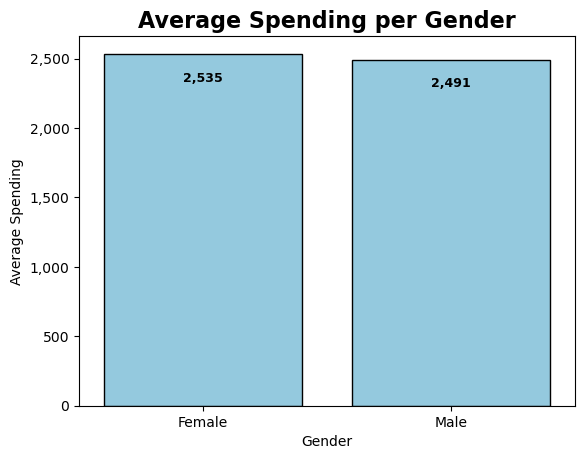

In [6]:
#Average spending per gender
query = """
    SELECT Gender, 
        AVG(Spending) as avg_spending
    FROM customer_demographics
    WHERE Spending IS NOT NULL
    GROUP BY Gender
    """

df_spend_gender = pd.read_sql(query, engine)

df_spend_gender_sorted = df_spend_gender.sort_values(by = "avg_spending", ascending = False)

ax = sn.barplot(x = "Gender", y = "avg_spending", data = df_spend_gender_sorted, color = "skyblue", edgecolor = "black")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.title("Average Spending per Gender", fontsize = 16, weight = "bold")
plt.xlabel("Gender")
plt.ylabel("Average Spending")

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,.0f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - (p.get_height() * 0.05)),  
        ha = "center", va = "top", fontsize = 9, color = "black", weight = "bold"
    )
    
plt.show()

#### Insight: Females spend more than Males in average by 44 which is trivial.

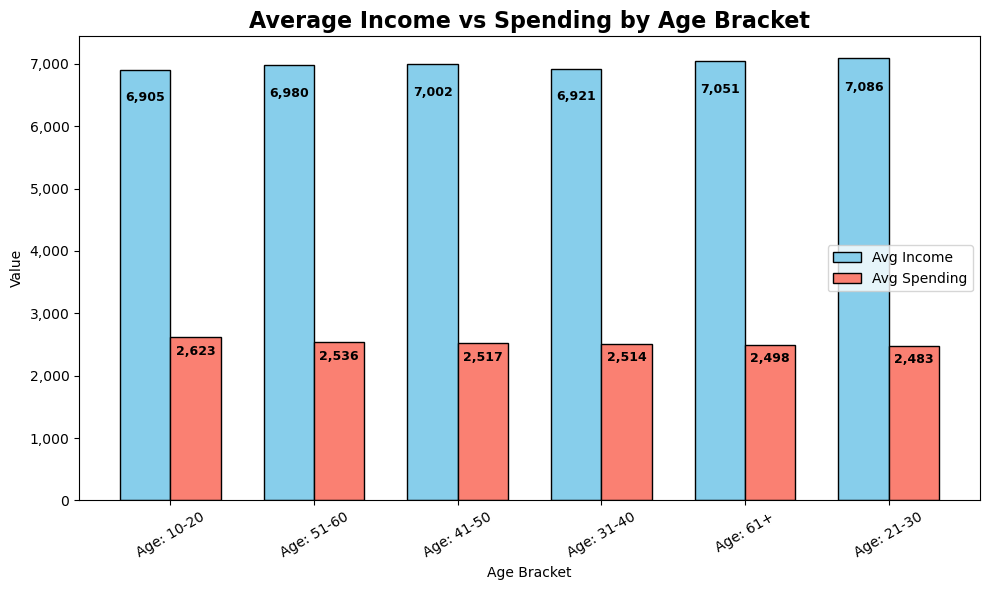

In [7]:
# Average income and spending per age bracket
query = """
    SELECT
        CASE
            WHEN Age BETWEEN 10 AND 20 THEN 'Age: 10-20'
            WHEN Age BETWEEN 21 AND 30 THEN 'Age: 21-30'
            WHEN Age BETWEEN 31 AND 40 THEN 'Age: 31-40'
            WHEN Age BETWEEN 41 AND 50 THEN 'Age: 41-50'
            WHEN Age BETWEEN 51 AND 60 THEN 'Age: 51-60'
            ELSE 'Age: 61+'
    END AS age_grouping, 
        COUNT(*) AS count, 
        AVG(monthly_income) as avg_income, 
        AVG(Spending) as avg_spending
    FROM customer_demographics
    WHERE monthly_income IS NOT NULL 
        AND Spending IS NOT NULL
    GROUP BY 
        CASE
            WHEN Age BETWEEN 10 AND 20 THEN 'Age: 10-20'  
            WHEN Age BETWEEN 21 AND 30 THEN 'Age: 21-30'  
            WHEN Age BETWEEN 31 AND 40 THEN 'Age: 31-40'  
            WHEN Age BETWEEN 41 AND 50 THEN 'Age: 41-50'  
            WHEN Age BETWEEN 51 AND 60 THEN 'Age: 51-60'  
            ELSE 'Age: 61+'
        END
    ORDER BY age_grouping
    """

df_income_spending_age_bracket = pd.read_sql(query, engine)

df_income_spending_age_bracket_sorted = df_income_spending_age_bracket.sort_values(by = "avg_spending", ascending = False)

x = np.arange(len(df_income_spending_age_bracket_sorted['age_grouping']))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10,6))

bars1 = ax.bar(x - width/2, df_income_spending_age_bracket_sorted['avg_income'], width, label = 'Avg Income', color = 'skyblue', edgecolor = 'black')
bars2 = ax.bar(x + width/2, df_income_spending_age_bracket_sorted['avg_spending'], width, label = 'Avg Spending', color = 'salmon', edgecolor = 'black')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

ax.set_title("Average Income vs Spending by Age Bracket", fontsize = 16, weight = 'bold')
ax.set_xlabel("Age Bracket")
ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(df_income_spending_age_bracket_sorted['age_grouping'], rotation = 30)
ax.legend(loc = "center right")
plt.tight_layout()

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,.0f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - (p.get_height() * 0.05)),  
        ha = "center", va = "top", fontsize = 9, color = "black", weight = "bold"
    )
    
plt.show()

#### Insight: Ages from 10-20 has the highest average spending while having the lowest average income. Ages 21-30 has the lowest average spending while having the highest average income

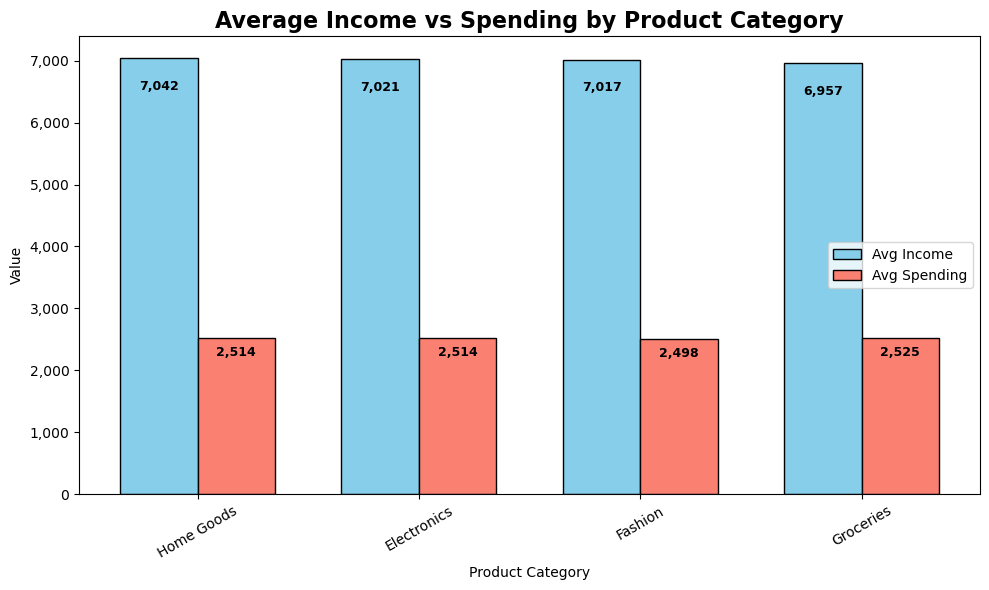

In [8]:
#Income vs product category
query = """
    SELECT Product_Category AS product_category,
        AVG(monthly_income) AS avg_income,
        AVG(Spending) AS avg_spending
    FROM customer_demographics
    WHERE monthly_income IS NOT NULL
        AND Spending IS NOT NULL
    GROUP BY product_category
    """

df_product_category = pd.read_sql(query, engine)

df_product_category_sorted = df_product_category.sort_values(by = "avg_income", ascending = False)

x = np.arange(len(df_product_category_sorted['product_category']))  
width = 0.35  

fig, ax = plt.subplots(figsize = (10,6))

bars1 = ax.bar(x - width/2, df_product_category_sorted['avg_income'], width, label = 'Avg Income', color = 'skyblue', edgecolor = 'black')
bars2 = ax.bar(x + width/2, df_product_category_sorted['avg_spending'], width, label = 'Avg Spending', color = 'salmon', edgecolor = 'black')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

ax.set_title("Average Income vs Spending by Product Category", fontsize= 16, weight = 'bold')
ax.set_xlabel("Product Category")
ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(df_product_category_sorted['product_category'], rotation = 30)
ax.legend(loc = "center right")
plt.tight_layout()

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,.0f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - (p.get_height() * 0.05)),  
        ha = "center", va = "top", fontsize = 9, color = "black", weight = "bold"
    )
    
plt.show()

#### Insight:  Most people spend on Home Goods and Electronics followed by Fashion then Groceries.

## Customer Transactions Analysis

### Questions to answer:

#### &emsp; 1. Which is the most popular product category?
#### &emsp; 2. What's the average spending per transaction by product category?
#### &emsp; 3. What's the monthly trend in transactions? 
#### &emsp; 4. Are the most purchases cheap?

In [9]:
#quick preview
query = """
    SELECT TOP 10 *
    FROM customer_transactions
    """

df_preview_1 = pd.read_sql(query, engine)
print(df_preview_1)

   Customer_ID       Name      Surname Gender  Birthdate  Transaction_Amount  \
0           29    Heather        Jones      M 1983-10-25               27.02   
1           51     Travis      Wheeler   None 2004-10-19             1898.56   
2           54  Christian    Hernandez      M 1981-10-25              166.30   
3           83       Chad  Fitzpatrick   None 1951-11-02              125.85   
4           90      Emily       Robles      M 2005-10-19               18.16   
5          105        Amy       Howard      M 1998-10-21               76.82   
6          110    Anthony        Petty      F 1976-10-26              231.57   
7          123    Rebecca     Thompson      M 1950-11-02              169.44   
8          132    Anthony     Franklin      F 2005-10-19              129.93   
9          154    Gregory       Willis      M 1991-10-23               12.85   

        Date               Merchant_Name    Category  
0 2023-09-20               Clarke-Garcia  Restaurant  
1 2023-05

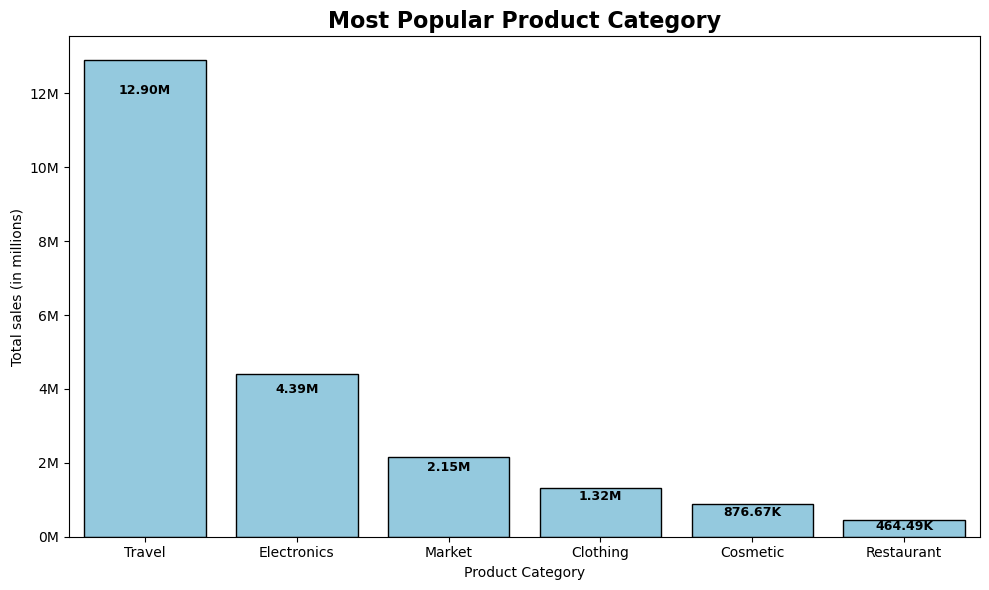

In [10]:
# most popular product
query = """
    SELECT Category, 
        SUM(Transaction_Amount) AS total_amount
    FROM customer_transactions
    WHERE Category IS NOT NULL
        AND Transaction_Amount IS NOT NULL
    GROUP BY Category
    ORDER BY total_amount DESC
    """

df_popular_product = pd.read_sql(query, engine)

plt.figure(figsize = (10,6))

ax = sn.barplot(x = "Category", y = "total_amount", data = df_popular_product, color = 'skyblue', edgecolor = 'black')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}M'))

plt.title("Most Popular Product Category", fontsize = 16, weight = "bold")
plt.xlabel("Product Category")
plt.ylabel("Total sales (in millions)")
plt.tight_layout()

for p in ax.patches:
    value = p.get_height()
    
    if value >= 1e6:
        label = f"{value/1e6:.2f}M"
    elif value >= 1e3:
        label = f"{value/1e3:.2f}K"
    else:
        label = f"{value:.0f}"
    
    ax.annotate(
        label,
        (p.get_x() + p.get_width() / 2., value - (value * 0.05)),  
        ha="center", va="top", fontsize=9, color="black", weight="bold"
    )
    
plt.show()

#### Insight: The most popular to people is Travelling with a 12.9M total sales. The least is the restaurants with a total of only 464.49K. 

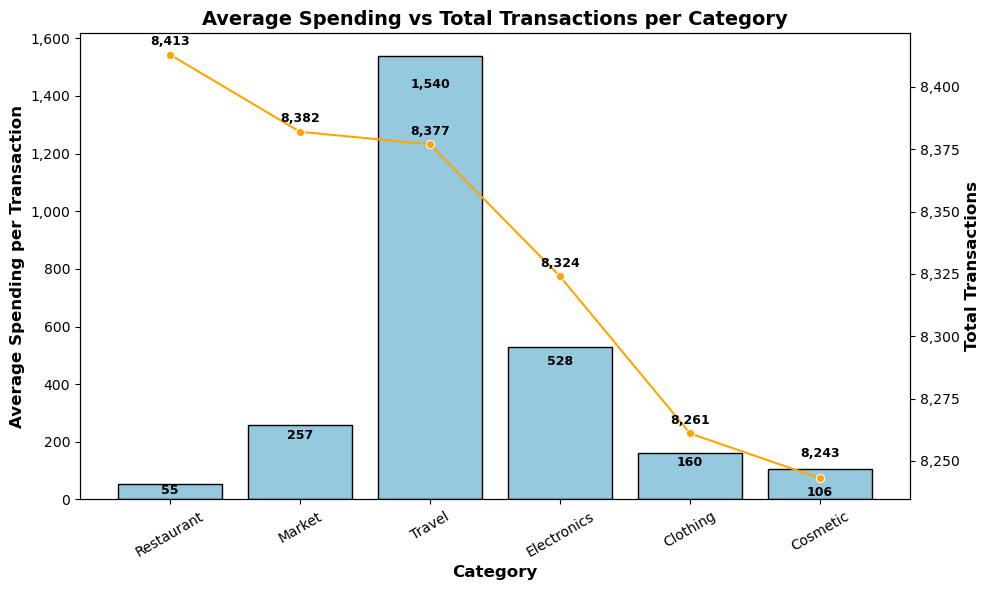

In [11]:
# average spending per transaction by category
query = """
    SELECT Category,
        COUNT(*) AS total_transactions,
        AVG(Transaction_Amount) AS average_amount
    FROM customer_transactions
    WHERE Category IS NOT NULL
        AND Transaction_Amount IS NOT NULL
    GROUP BY Category
    ORDER BY total_transactions DESC,
        average_amount DESC
    """

df_average_spending = pd.read_sql(query, engine)

fig, ax1 = plt.subplots(figsize = (10,6))

sn.barplot(x = "Category", y = "average_amount", data = df_average_spending, ax = ax1, color = "skyblue", edgecolor = "black")

ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

ax1.set_ylabel("Average Spending per Transaction", fontsize = 12, weight = "bold")
ax1.set_xlabel("Category", fontsize = 12, weight = "bold")
ax1.tick_params(axis = "x", rotation = 30)

for i, p in enumerate(ax1.patches):
    value = p.get_height()
    
    if i == len(ax1.patches) - 1: 
        ax1.annotate(
            f"{value:,.0f}",
            (p.get_x() + p.get_width()/2., 3),  
            ha="center", va="bottom",
            fontsize=9, weight="bold", color="black"
        )
    else:
        ax1.annotate(
            f"{value:,.0f}", 
            (p.get_x() + p.get_width()/2., value - (0.05 * value)),
            ha="center", va="top",
            fontsize=9, weight="bold", color="black"
        )

ax2 = ax1.twinx()

sn.lineplot(x = "Category", y = "total_transactions", data = df_average_spending, ax = ax2, color = "orange", marker = "o")

ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

ax2.set_ylabel("Total Transactions", fontsize = 12, weight = "bold")

for i, (x, y) in enumerate(zip(df_average_spending["Category"], df_average_spending["total_transactions"])):
    offset = 15 if i == len(df_average_spending)-1 else 7  
    ax2.annotate(
        f"{y:,.0f}",
        (x, y),
        textcoords="offset points",
        xytext=(0,offset),
        ha="center",
        color="black",
        fontsize=9,
        weight="bold"
    )

plt.title("Average Spending vs Total Transactions per Category", fontsize = 14, weight = "bold")
plt.tight_layout()

plt.show()

#### Insight: Travelling dominates in spending and also has a high number of transactions. Restaurants have the highest number of transactions but has the lowest spending.

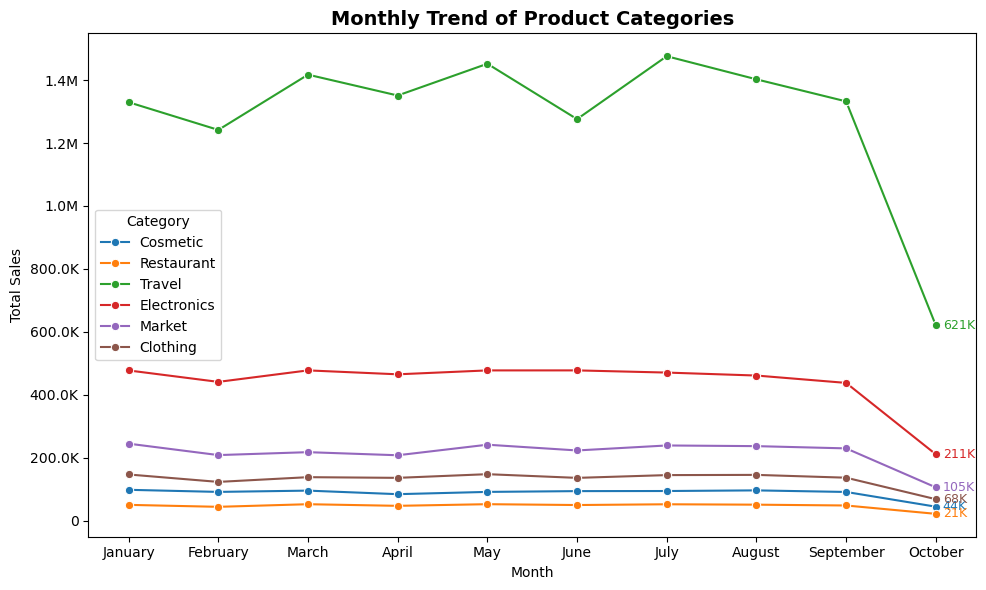

In [12]:
# monthly trend
query = """
         SELECT DATENAME(month, Date) AS month_name,
            MONTH(Date) AS month_number,
            Category,
            SUM(Transaction_Amount) AS total_amount
    FROM customer_transactions
    WHERE Date IS NOT NULL
        AND Transaction_Amount IS NOT NULL 
    GROUP BY DATENAME(month, Date), MONTH(Date), Category
    ORDER BY month_number
    """

df_monthly_trend = pd.read_sql(query, engine)

plt.figure(figsize = (10,6))

ax = sn.lineplot(data = df_monthly_trend, x = "month_name", y = "total_amount", hue = "Category", marker = "o")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: next(
            (f"{x/scale:.1f}{suffix}" for scale, suffix in [(1e6, "M"), (1e3, "K")] 
             if x >= scale),
            str(int(x))
        )
    )
)

for line in ax.lines:
    x, y = line.get_xdata(), line.get_ydata()
    if len(x) == 0 or len(y) == 0:  
        continue
    
    val = y[-1]
    for div, suffix, decimals in [(1_000_000, "M", 1), (1_000, "K", 0), (1, "", 0)]:
        if abs(val) >= div:
            label = f"{val/div:.{decimals}f}{suffix}"
            break

    ax.annotate(label, 
                (x[-1], y[-1]),
                xytext=(5, 0), textcoords="offset points",
                va="center", fontsize=9, color=line.get_color())

plt.title("Monthly Trend of Product Categories", fontsize = 14, weight = "bold")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()

plt.show()

#### Insight: The peak season for travel is July and for Electronics is January. Restaurant has almost linear sales throughout January to October. They all drop a significanty amount during October.

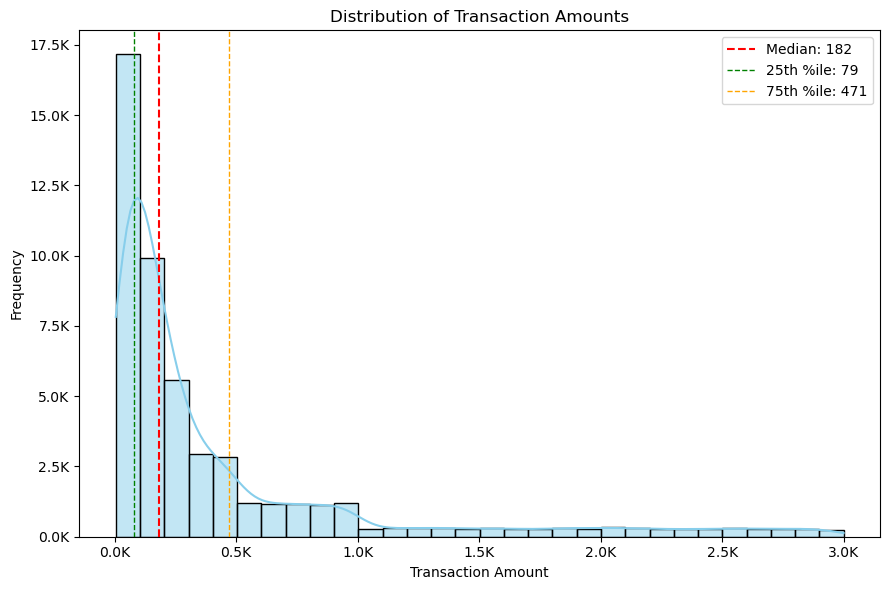

In [13]:
# distribution without skew
query = """
    SELECT *
    FROM customer_transactions
    WHERE Transaction_Amount IS NOT NULL
    """

df_histo = pd.read_sql(query, engine)

plt.figure(figsize = (9,6))

ax = sn.histplot(df_histo["Transaction_Amount"], bins = 30, kde = True, color = "skyblue")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.1f}K'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.1f}K'))

median = df_histo["Transaction_Amount"].median()
p25 = np.percentile(df_histo["Transaction_Amount"], 25)
p75 = np.percentile(df_histo["Transaction_Amount"], 75)

plt.axvline(median, color="red", linestyle="--", linewidth=1.5, label=f"Median: {median:,.0f}")
plt.axvline(p25, color="green", linestyle="--", linewidth=1, label=f"25th %ile: {p25:,.0f}")
plt.axvline(p75, color="orange", linestyle="--", linewidth=1, label=f"75th %ile: {p75:,.0f}")

plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Transaction Amounts")
plt.legend()
plt.tight_layout()

plt.show()

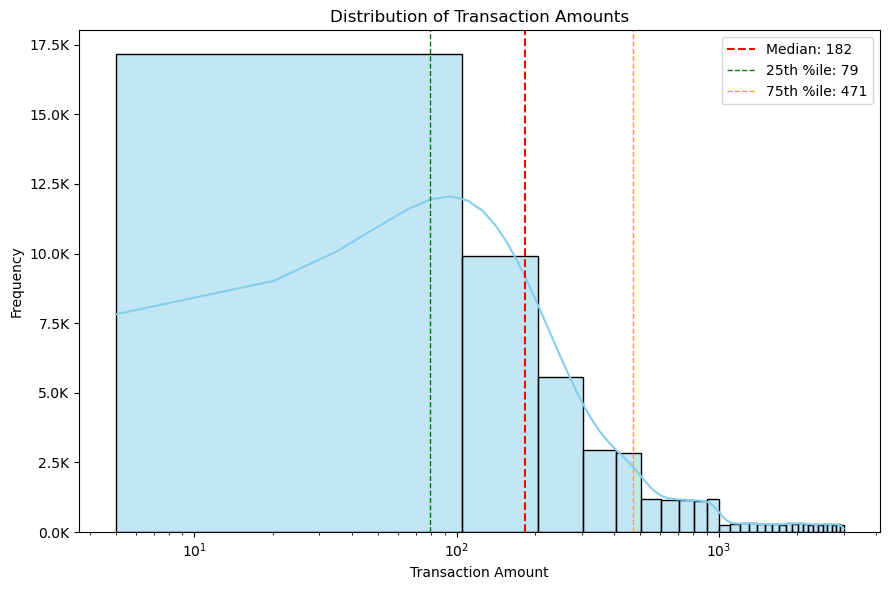

In [14]:
# distribution with skew
plt.figure(figsize = (9,6))

ax = sn.histplot(df_histo["Transaction_Amount"], bins = 30, kde = True, color = "skyblue")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.1f}K'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.1f}K'))

median = df_histo["Transaction_Amount"].median()
p25 = np.percentile(df_histo["Transaction_Amount"], 25)
p75 = np.percentile(df_histo["Transaction_Amount"], 75)

plt.axvline(median, color="red", linestyle="--", linewidth=1.5, label=f"Median: {median:,.0f}")
plt.axvline(p25, color="green", linestyle="--", linewidth=1, label=f"25th %ile: {p25:,.0f}")
plt.axvline(p75, color="orange", linestyle="--", linewidth=1, label=f"75th %ile: {p75:,.0f}")

plt.xscale("log")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Transaction Amounts")
plt.legend()
plt.tight_layout()

plt.show()

#### Insight: Most transactions are on the lower end, but there are few very large purchases pulling the average up.